# Create Mock Data to the Y3 Pipeline

To validate and test the y3 cluster pipeline we make a simplified mock data of the Buzzard v.1.9.8 dataset. 

Pasting:
- Halo Catalog (truth)
- Paste Mass-Observable Relation
- Shear/$\Delta \Sigma$ profiles (based on Heidi's work)


In [1]:
#!/usr/bin/env python
import os, fitsio

import sys
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

## Halo Catalog

Before applying a redMaPPer selection we use the true dark matter buzzard mock halo catalog. 

In [2]:
from fileLoc import FileLocs

floc = FileLocs(machine='nersc')
print('halo file name: %s'%floc.halo_run_fname)

halo file name: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/buzzard-1.9.8_3y3a_run_halos_lambda_chisq_mu_star.fit


This file contains all buzzard halos with $ M_{200} >10^{12}M_{\odot}$. This catalog also has redMaPPer outputs and $\mu_{\star, \rm true}$.

For more information how this file was created take a look at the source code.
https://github.com/estevesjh/muStarSigmaProfiles/blob/main/notebooks/0.CreateCopacabanaCatalogs.ipynb

In [3]:
### Read Files
data_h, h = fitsio.read(floc.halo_run_fname, header=True)
data, h  = fitsio.read(floc.profile_output_fname, header=True)

#### discard bad halos ####
cosi_all = data['cosi']
pid_all  = data['pid']
redshift_all = data['redshift']
select_good = (pid_all==-1)&(cosi_all>=0)&(cosi_all<=1)##&(self.lam_all > 3)
select_good = select_good & ((redshift_all < 0.33)|(redshift_all > 0.37))

# new variables
redshift = redshift_all[select_good]
profile_all = data['Sigma'][select_good,:]
logMvir = np.log10(data['Mvir'])[select_good]

print('all vs good',len(cosi_all), len(cosi_all[select_good]))

all vs good 1418121 611205


In [4]:
redshift_pdz = data_h['Z']

## Selection Like Y3

I apply two selections, $M_{vir}>10^{13}$ and $z \in [0.2, 0.65]$.

In [5]:
zmin, zmax = 0.2, 0.65
logM_min = 13.0

In [6]:
from astropy.table import Table, join
sel = (redshift>=zmin)&(redshift<=zmax)
sel&= (logMvir>=logM_min)

_mock = Table(data[select_good][sel])

print('Number of halos in mock: %i'%len(_mock))

Number of halos in mock: 580668


In [7]:
_data_h = Table(data_h)
_data_h.rename_column('HALOID', 'haloid')

mock = join(_mock, _data_h)

In [8]:
mock

haloid,Mvir,redshift,cosi,pid,rs,M200m,R200m,Sigma,DeltaSigma,rho,M200,R200,MEM_MATCH_ID,RA,DEC,Z,Z_COS,P_BCG,Z_LAMBDA,LAMBDA_CHISQ,LAMBDA_CHISQ_E,LAMBDA_CHISQ_ZORIG,SCALEVAL,LAMBDA_ZRED,LAMBDA_ZRED_E,MASKFRAC,GEOMASKFRAC,R_LAMBDA,R_MASK,Z_LAMBDA_E,NCROSS,Z_LAMBDA_NITER,DLAMBDA_DZ,DLAMBDA_DZ2,DLAMBDAVAR_DZ,DLAMBDAVAR_DZ2,C_LAMBDA,C_LAMBDA_ERR,MAG_LAMBDA_ERR,PZBINS,PZ,Z_LAMBDA_RAW,Z_LAMBDA_E_RAW,BCG_SPEC_Z,LIM_EXPTIME,LIM_LIMMAG_DERED,LIM_LIMMAG,LIM_LIMMAG_HARD,MU_STAR,MU_STAR_ERR
int32,float32,float64,float64,int32,float64,float32,float64,float64[15],float64[15],float64[10],float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32[3],float32[3],float32[4],float32[21],float32[21],float32,float32,float32,float32,float32,float32,float32,float64,float64
927011,67180000000000.0,0.32129502296447754,0.0493361,-1,0.153435,71999500000000.0,1.02684,687.6303158625412 .. 17.94479240757588,-21.009727248105214 .. 2.303207391199313,2178226498771693.5 .. 503991597033.93005,67180000000000.0,0.920502,83659,317.3129287824625,-2.2699395003325264,0.32129502,0.32240096,1.0,0.29508114,11.308149,4.421,11.308149,1.5201979,5.496004,1.8859599,0.34834605,0.0,0.6466634,0.96999514,0.021968598,0,4.0,-0.13628136,-813.556,-25.539,-7945.5103,1.5532275 .. 0.30276462,0.004215956 .. 0.001953539,0.003551543 .. 0.0,0.1319275 .. 0.4582348,4.6803337e-19 .. 1.6777544e-06,0.30003133,0.019447086,-1.0,0.060046393,21.323307,21.323307,23.33665,55.13490186726909,15.129583717781587
927998,19660000000000.0,0.3205868899822235,0.178295,-1,0.183352,22303100000000.0,0.694974,311.34160504036714 .. 18.374717459592997,37.19347864947478 .. 1.2994938365065096,1373541979616634.8 .. 305181131216.41174,19660000000000.0,0.61103,583836,317.75202896886884,-1.949667563663084,0.3205869,0.32168326,1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.042421903,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,-1.0 .. -1.0,-1.0 .. -1.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,-1.0,0.19611365,22.218992,22.231089,23.33665,41.92753971791975,14.28440131000884
2545389,68890000000000.0,0.27058446407318115,0.37468,-1,0.223423,91154710000000.0,1.11086,469.1737007476693 .. 15.90097191373355,115.09039698599864 .. 2.753597969323336,2219173286702298.8 .. 1519260804499.2036,68890000000000.0,0.917785,79738,307.15073025389347,-42.0517754044981,0.27058446,0.27059728,1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.027480915,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,-1.0 .. -1.0,-1.0 .. -1.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,-1.0,0.17292078,22.134556,22.134556,23.33665,75.17978438169001,28.065401761466184
2545393,88940000000000.0,0.27038249373435974,0.557151,-1,0.55728,105052300000000.0,1.16474,542.0784591288408 .. 16.14773575478276,-57.00905916180685 .. 2.5884544516698047,1642214180825270.8 .. 920412980488.0205,88940000000000.0,0.999439,49132,307.27470671757794,-42.05313550692125,0.2703825,0.27077192,1.0,0.2726077,12.909922,2.2422812,12.909922,1.0107747,8.592764,1.683498,0.011844758,0.0,0.6640254,0.99603814,0.012795136,1,7.0,16.436996,-4891.07,54.50159,-19902.953,1.4195611 .. 0.29340506,0.0006993837 .. 0.00028456797,0.0005785313 .. 0.0,0.19574621 .. 0.3494692,6.227082e-10 .. 2.574587e-06,0.27617714,0.009283012,-1.0,0.17907387,22.145226,22.161373,23.33665,81.77789884880814,21.3046707925232
2545753,76890000000000.0,0.263835608959198,0.125772,-1,0.162836,81108270000000.0,1.06845,531.6249357975245 .. 17.51952583340207,124.49326826468936 .. 1.566832787886304,2128660225006729.0 .. 356406746880.90045,76890000000000.0,0.950669,64954,308.4656671879389,-39.82394748123761,0.2638356,0.2644128,1.0,0.24406444,12.757372,2.730836,12.757372,1.1628395,7.357111,1.6438206,0.14655606,0.0,0.6624487,0.9936731,0.010842432,1,5.0,-3.626756,-878.77856,8.034127,-3581.3113,1.3601099 .. 0.27888802,0.0005536285 .. 0.00039728833,0.0004455281 .. 0.0,0.17095098 .. 0.3171779,1.34302005e-11 .. 2.8216637e-06,0.24525408,0.0085574

In [9]:
## clear memory
data_h = data = 0
_mock = _data_h = 0

## Distributions

(array([ 19717.,  35200.,  38023.,  43933.,  85547., 107626.,  96489.,
         67724.,  58388.,  30396.]),
 array([-61.5816496 , -45.36618242, -29.15071525, -12.93524807,
          3.2802191 ,  19.49568628,  35.71115345,  51.92662063,
         68.1420878 ,  84.35755498, 100.57302216]),
 <BarContainer object of 10 artists>)

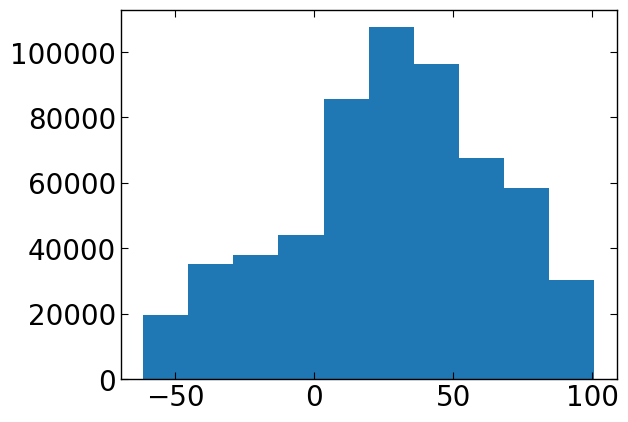

In [10]:
ra = mock['RA']
ix, = np.where(ra>180)
ra[ix] = ra[ix]-360
plt.hist(ra)

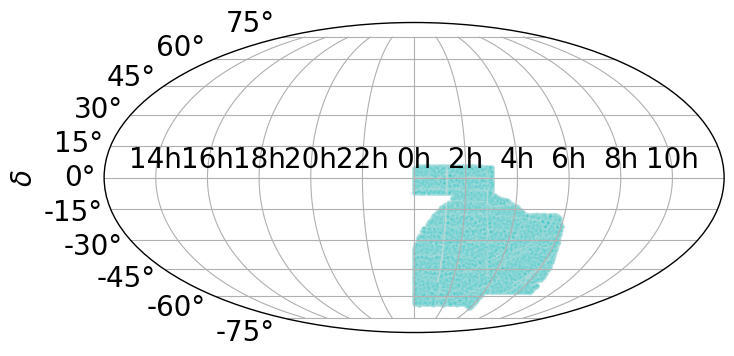

In [11]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# Plotting sky distribution
ra = mock['RA']
ix, = np.where(ra>180)
ra[ix] = ra[ix]-360
dec= mock['DEC']

c = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree))
#Coordinates needs to be in radians from (-pi,pi) & (-pi/2, pi/2)
a = c.ra.to('radian').value
d = c.dec.to('radian').value

#make figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='mollweide' ) # hammer or mollweide, aitoff, or lambert 
ax.scatter(a,d, marker='.', color='c', alpha=0.05, edgecolors='w')
ax.grid(True)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h']) 
plt.ylabel(r'$\delta$')
plt.show()


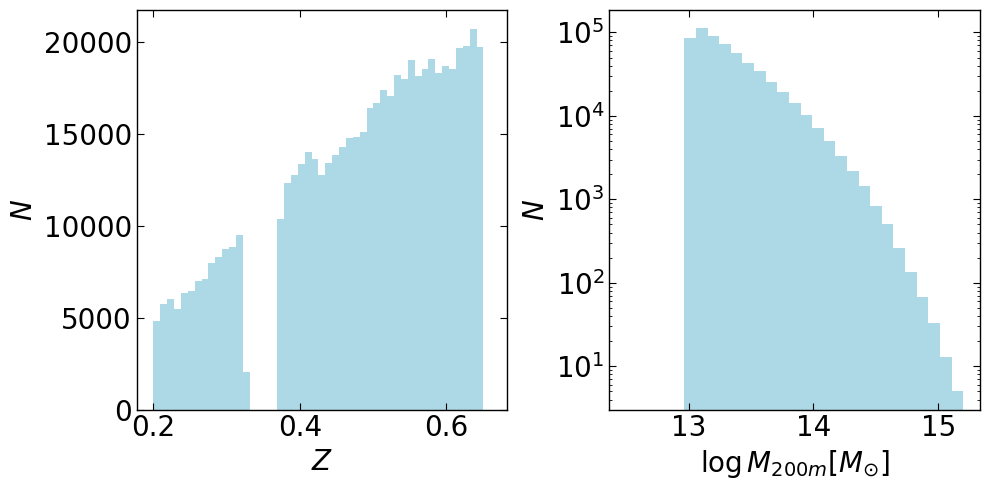

In [12]:
# Histrograms of mass and redshifts 
logMvir = np.log10(mock['Mvir'])
z = np.array(mock['redshift'])

zbins = np.linspace(0.2, 0.66, num=50)
#mbins = np.linspace(3e13, 2e15, num=30)
mbins = np.linspace(12.5, 15.2, num=30)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(z, bins=zbins, color='lightblue', density=False)
axes[0].set_xlabel('$Z$')
axes[0].set_ylabel('$N$')

axes[1].hist(logMvir, bins=mbins, color='lightblue')
axes[1].set_xlabel('$\log M_{200m} [M_{\odot}]$')
axes[1].set_ylabel('$N$')
axes[1].set_yscale('log')
fig.tight_layout()
plt.show()

The break on redshift is a selection to avoid the switch of the simulation box resolution. 

In [13]:
print('Save file: %s'%floc.mock_fname)
mock.write(floc.mock_fname, format='fits', overwrite=True)

Save file: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_v0.fits


# Mass Observable Relation

Altough we have redMaPPer richness in our catalog. We will first use a fixed one in order for testing and validation. 

The lines below were compied from Maria's notebook.


## Assigning richness and $\mu_{\star}$ 

We know the mass-calibration results from McClintock et al (2018) and Pereira et. al (2020). 

### Scaling Relatioons (with redshift evolution)

We have that

$$ \langle M|\mu_{\star},z \rangle =  M_0 \left( \frac{\mu_{\star}}{5.2 \times 10^{12}} \right)^a \left( \frac{1+z}{1.35} \right)^b. $$

Taking the log

$$ \langle \log M | \mu_{\star},z \rangle = a  \log \left( \frac{\mu_{\star}}{5.2 \times 10^{12}} \right) + b \log \left( \frac{1+z}{1.35} \right) + c $$



Inverting this relation, we get:

$$ \langle \log \mu_{\star}|M,z \rangle = \frac{1}{a} \left( \log M - b \log \left( \frac{1+z}{1.35}\right) - c  \right) + \log(5.2 \times 10^{12}), $$

whith $a=0.77 \pm 0.06, \, b= -1.54 \pm 0.37 \, \mathrm{and} \, c=\log M_0 = 14.30 \pm 0.02 \, [M_\odot]$.



Similarly, for log &lambda;:

$$ \langle \log \lambda|M,z \rangle = \frac{1}{a} \left( \log M - b \log \left( \frac{1+z}{1.35}\right) - c  \right) + \log(40), $$

whith $a=1.36 \pm 0.05, \, b=-0.30 \pm 0.31 \, \mathrm{and} \, c= \log M_0 = 14.49 \pm 0.02 \,[M_\odot] $.



And doing error propagation to get the error, we get (**this is wrong**):

$$ \sigma_{\log \mu_{\star|M,z}} = \sqrt{ \left( - \left( \log M - b \log\left( \frac{1+z}{1.35}\right) \right) a^{-2} \sigma_a \right)^2 + \left( -\frac{1}{a} \log \left( \frac{1+z}{1.35}\right) \sigma_b \right)^2 + \left(-\frac{\sigma_c}{a}\right)^2   } $$


Note that all masses are (or were converted to) in units of $M_{200m} [M_{\odot}]$.


Now, we should assign &lambda; and $\mu_{\star}$ for this sample. Jim have found that the relationship between observables _s_ and mass _M_ should be in the form: 

$$\langle \log s | M \rangle = \frac{\log M - b}{a} - \frac{\beta \ln 10}{a^2} \sigma^2_{\log M} $$


## Adding scatter

The variance of the mean relations above between the observables s and mass M should be in the form:

$$ \sigma_{\log s} = \frac{\sigma_{\log M}}{a}$$


In [14]:
def get_log_lambda(logM, z, a, b, c):
    return (1./a)*(logM - b*np.log10((1+z)/1.35) - c) + np.log10(40)

def get_log_mustar(logM, z, a, b, c):
    return (1./a)*(logM - b*np.log10((1+z)/1.35) - c) + np.log10(5.2e12)

def get_sigma_log_mustar(logM, z, a, sigma_a, b, sigma_b, c, sigma_c):
    return np.sqrt( ( -a**(-2)*sigma_a*(logM - b*np.log10((1.+z)/1.35)) )**2 + ( (-1./a)*np.log10((1+z)/1.35)*sigma_b )**2+ (-sigma_c/a)**2 )


In [15]:
# getting mock data

log_M = np.log10(mock['Mvir'])
z = np.array(mock['redshift'])

In [16]:
# Assigning lambda and mustar for the halos
mpivot = 5.2e12

# assigning lambda
log_lambda = get_log_lambda(log_M, z, 1.36, -0.30, 14.49)

#Assuming 10% scatter...
sig_loglam = 0.15

#Adding scatter
log_lambda_sc = np.array([np.random.normal(n, sig_loglam) for n in log_lambda])

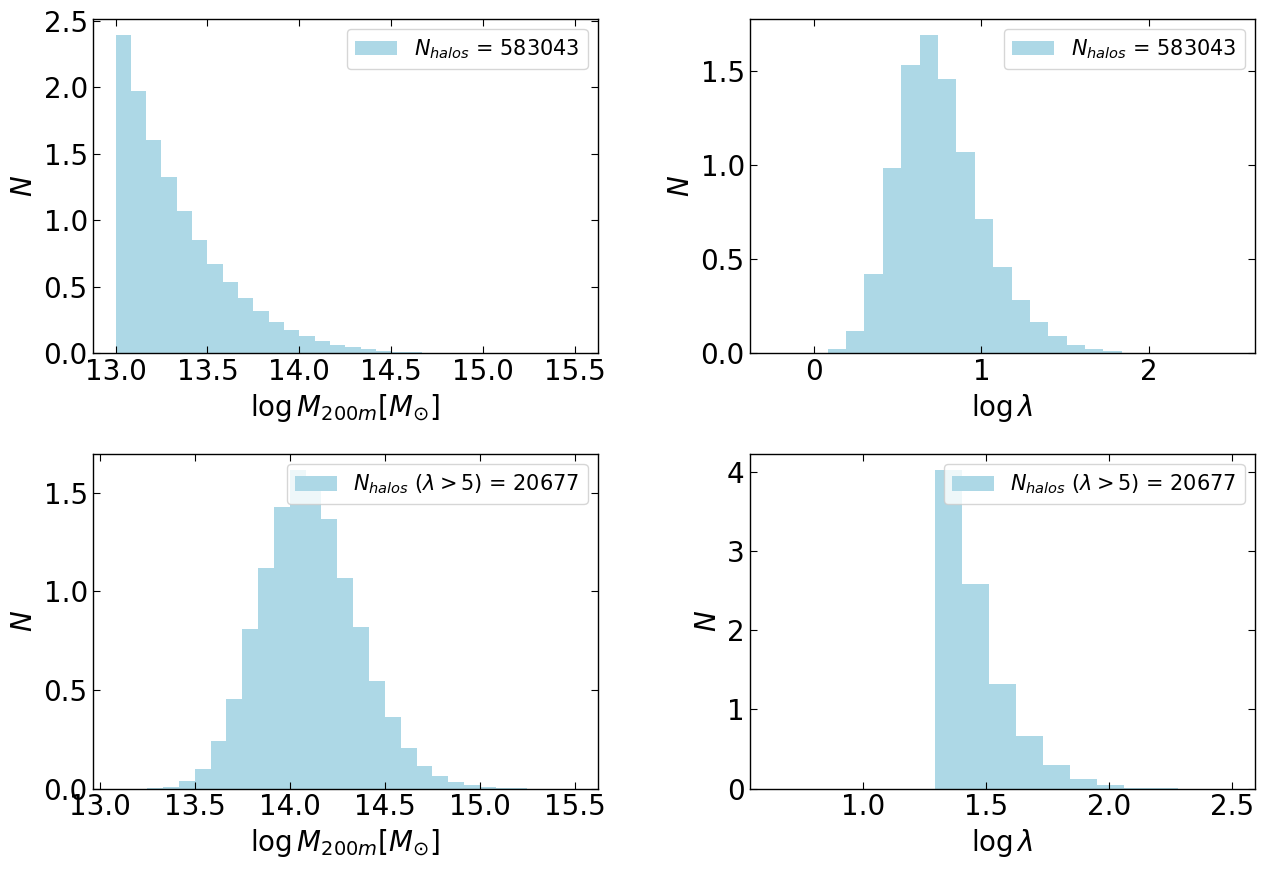

In [17]:
# Histrograms of mass and richness

mbins   = np.linspace(13.0, 15.5, num=31)
rbins   = np.linspace(-0.25, 2.5, num=26)
N       = len(log_lambda_sc)

log_lg5 = (log_lambda_sc>=np.log10(20))
Nlg5    = len(log_lambda_sc[log_lg5])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes[0,0].hist(log_M, bins=mbins, color='lightblue', density=True, label="$N_{halos}$ = "+ str(N))
axes[0,0].set_xlabel('$\log M_{200m} [M_{\odot}]$')
axes[0,0].set_ylabel('$N$')
axes[0,0].legend(loc="best", fontsize=15)

axes[0,1].hist(log_lambda_sc, bins=rbins, color='lightblue', density=True, label="$N_{halos}$ = "+ str(N))
axes[0,1].set_xlabel('$\log \lambda$')
axes[0,1].set_ylabel('$N$')
axes[0,1].legend(loc="best", fontsize=15)

axes[1,0].hist(log_M[log_lg5], bins=mbins[1:,], color='lightblue', density=True, label="$N_{halos}$ ($\lambda>5$) = "+ str(Nlg5))
axes[1,0].set_xlabel('$\log M_{200m} [M_{\odot}]$')
axes[1,0].set_ylabel('$N$')
axes[1,0].legend(loc="best", fontsize=15)

axes[1,1].hist(log_lambda_sc[log_lg5], bins=rbins[8:,], color='lightblue', density=True, label="$N_{halos}$ ($\lambda>5$) = "+ str(Nlg5))
axes[1,1].set_xlabel('$\log \lambda$')
axes[1,1].set_ylabel('$N$')
axes[1,1].legend(loc="best", fontsize=15)

fig.subplots_adjust(wspace=0.3, hspace=0.3)
#fig.tight_layout()
plt.show()

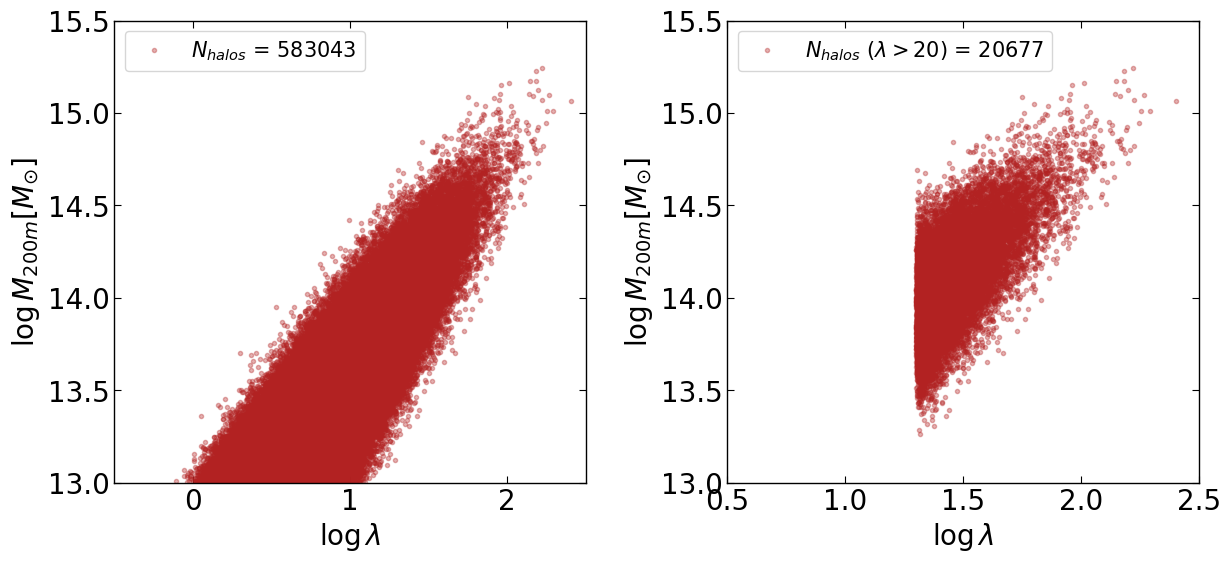

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

axes[0].plot(log_lambda_sc, log_M, '.', color='firebrick', alpha=0.35, label='$N_{halos}$ = '+str(N))
axes[0].set_xlabel('$\log \lambda$')
axes[0].set_ylabel('$\log M_{200m} [M_{\odot}]$')
axes[0].set_xlim(-0.5, 2.5)
axes[0].set_ylim(13.0, 15.5)
axes[0].legend(loc="best", fontsize=15)

axes[1].plot(log_lambda_sc[log_lg5], log_M[log_lg5], '.', color='firebrick', alpha=0.35,  label='$N_{halos}$ ($\lambda>20$) = '+str(Nlg5)) 
axes[1].set_xlabel('$\log \lambda$')
axes[1].set_ylabel('$\log M_{200m} [M_{\odot}]$')
axes[1].set_xlim(0.5, 2.5)
axes[1].set_ylim(13.0, 15.5)
axes[1].legend(loc="best", fontsize=15)

fig.subplots_adjust(wspace=0.3)
plt.show()

# Adding correlation between the observables


We need to recompute the mean relation <**s**|M>, where **s** is as vector of obersvables {log &lambda;, log $\mu_{\star}$}. From Rozo et al. 2014 and Evrard et al. 2014, Oguri et al. 2018, we have:


$$\langle \mathbf{s} | M \rangle = \left[ \mathbf{\alpha}^T \mathbf{C}^{-1} (\mathbf{\mu} - \pi) - \mathbf{\beta} \ln{(10)} \right] \sigma_{\mathbf{s}|M}^2,$$
with

$$ \sigma_{\mathbf{s}|M}^2 = \left( \mathbf{\alpha}^T \mathbf{C}^{-1}  \mathbf{\alpha} \right)^{-1}   $$
where

$$ \mathbf{\mu} = \begin{pmatrix}
\log M \\
\log M 
\end{pmatrix} $$

$$ \mathbf{\alpha} = \begin{pmatrix}
a_{\lambda} \\
a_{\mu_{\star}} 
\end{pmatrix} $$

$$ \mathbf{\pi} = \begin{pmatrix}
b_{\lambda} \\
b_{\mu_{\star}} 
\end{pmatrix} $$

$$ \mathbf{\beta} = \begin{pmatrix}
\beta_{\lambda} \\
\beta_{\mu_{\star}} 
\end{pmatrix} $$


$$ \mathbf{C} = \begin{pmatrix}
\sigma_{\log \lambda | M}^2 & r \cdot \sigma_{\log \lambda | M}  \cdot \sigma_{\log \mu_\star|M}  \\
r \cdot  \sigma_{\log \mu_\star|M} \cdot \sigma_{\log \lambda|M}  & \sigma_{\log \mu_\star|M}^2 
\end{pmatrix} $$

The pearson correlation for log &lambda; and log $\mu_{\star}$ is r =0.622. 

Since the scatters can be computed as

$$ \sigma_{\log{s}|M} = \frac{ \sigma_{\log{M}|s} }{a_s}, $$

we have that

$$ \sigma_{\log{\lambda}|M} = \frac{ \sigma_{\log{M}|\lambda} }{a_\lambda} = \frac{0.13}{1.36} = 0.0956$$

$$ \sigma_{\log{\mu_\star}|M} = \frac{ \sigma_{\log{M}|\mu_\star} }{a_{\mu_\star}} = \frac{0.11}{0.77} = 0.1429$$


In [19]:
alphas = np.array([ [1.36], [1.0] ])
alphas_T = np.transpose(alphas)

pis = np.array([ [14.49], [14.30] ])

betas = np.array([ [3.5], [1.67] ])

r = 0.622
sig_lMlam = 0.13
sig_lMmus = 0.11
sig_llamM = 0.0956
sig_lmusM = 0.1429

C = np.array([[ sig_llamM**2, r*sig_llamM*sig_lmusM],[r*sig_llamM*sig_lmusM, sig_lmusM**2]])
iC = np.linalg.inv(C) 


In [20]:
def s_given_M_corr(logM, alphas_, alphasT_, icov, pis_, betas_ ):

    sig2_sM = (np.dot(np.dot(alphas_T, iC), alphas))**(-1) #(np.dot(alphas_T * iC, alphas) )**(-1) 
    sig2_sM = sig2_sM[0][0]                                #just get the number from this 1x1 'matrix'

    lamM=[]
    muM =[]
    for i in range(len(logM)):
        mus = np.array([ [log_M[i]], [log_M[i]] ]) 
        sM = (np.dot(np.dot(alphas_T,iC),(mus-pis)) - betas*np.log(10)) * sig2_sM
        lamM.append(sM[0]) 
        muM.append(sM[1])

    sM_scatter = np.sqrt(sig2_sM)

    #print sM
    print(sM_scatter)
    return np.array(lamM), np.array(muM), sM_scatter 
    


In [21]:
sM0, sM1, sM_sig = s_given_M_corr(log_M, alphas, alphas_T, iC, pis, betas) 

lpivot = 40.
mpivot = 5.2e12

lambda_corr      = lpivot*10**sM0
log_lambda_corr   = np.log10(lambda_corr)
#print log_lambda_corr, lambda_corr

mustar_corr     = mpivot*10**sM1 
log_mustar_corr = np.log10(mustar_corr)

#print log_mustar_corr, mustar_corr

print(sM_sig)

0.06934362857768142
0.06934362857768142


In [22]:
#Adding scatter

log_lambda_corr_sc = np.array([np.random.normal(n, sM_sig) for n in log_lambda_corr])
log_mustar_corr_sc = np.array([np.random.normal(n, sM_sig) for n in log_mustar_corr])

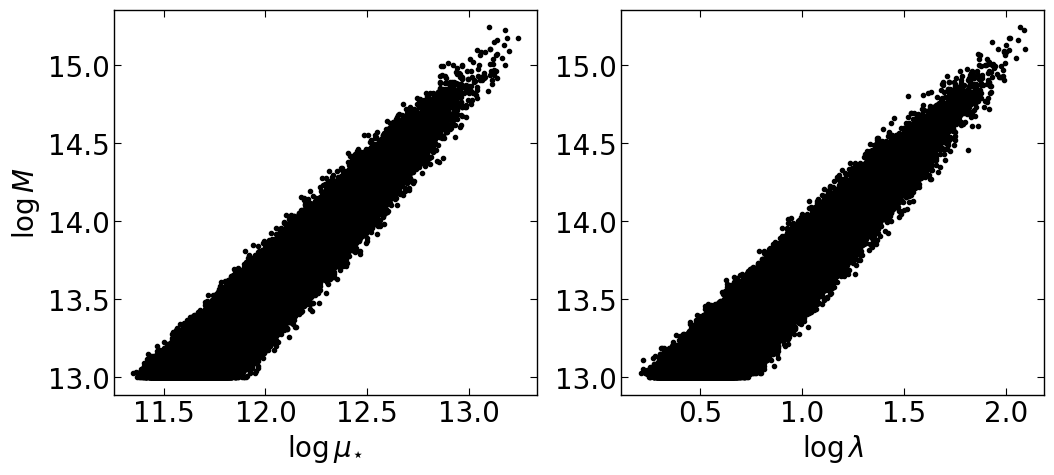

In [23]:
fig = plt.figure(figsize=(12, 5))
#mean relation Mxmu* with scatter
plt.subplot(121)
plt.plot(log_mustar_corr_sc, log_M, 'k.')
plt.xlabel('$\log \mu_{\star}$')
plt.ylabel('$\log M$')

#mean relation Mx lambda with scatter
plt.subplot(122)
plt.plot(log_lambda_corr_sc, log_M, 'k.')
plt.xlabel('$\log \lambda$')
# plt.ylabel('$\log M$')
plt.show()

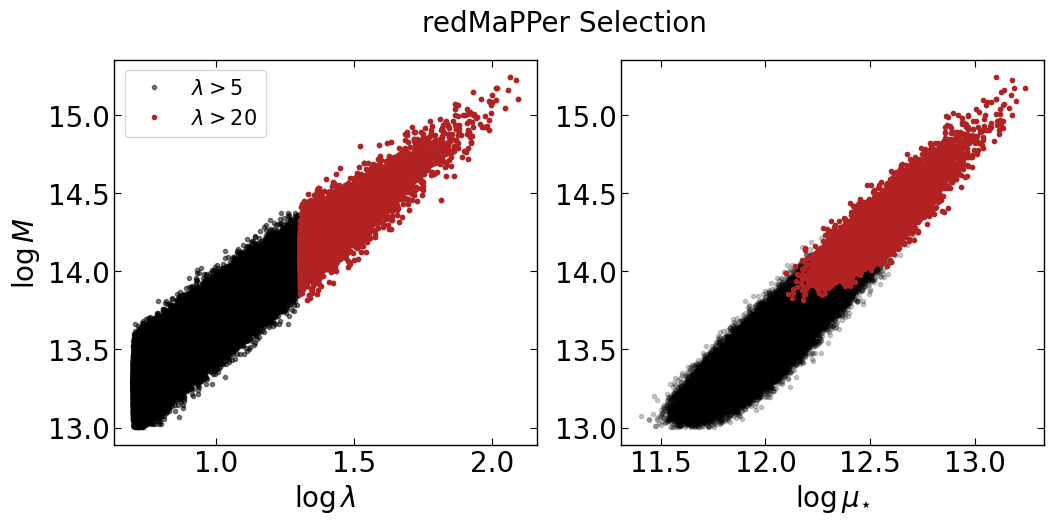

In [24]:
log_lg20 = log_lambda_corr_sc.flatten() > np.log10(20)
log_lg5 = log_lambda_corr_sc.flatten() > np.log10(5)
mask = log_lg20

fig = plt.figure(figsize=(12, 5))

#mean relation Mx lambda with scatter
plt.subplot(121)
plt.plot(log_lambda_corr_sc[log_lg5], log_M[log_lg5], '.', color='k', alpha=0.5, label=r'$\lambda>5$')
plt.plot(log_lambda_corr_sc[log_lg20], log_M[log_lg20], '.', color='firebrick', label=r'$\lambda>20$')
plt.xlabel('$\log \lambda$')
plt.ylabel('$\log M$')
plt.legend(fontsize=15)


#mean relation Mxmu* with scatter
plt.subplot(122)
plt.plot(log_mustar_corr_sc[log_lg5], log_M[log_lg5], '.', color='k', alpha=0.2)
plt.plot(log_mustar_corr_sc[log_lg20], log_M[log_lg20], '.', color='firebrick')
plt.xlabel('$\log \mu_{\star}$')

fig.suptitle('redMaPPer Selection', fontsize=20)
plt.savefig('mock_mor_redmapper_sel.png', dpi=75, facecolor='w', transparent=False)

In [25]:
# add mu-star and lambda to the mocks
mock['lambda_mor'] = 10**log_lambda_corr_sc.flatten()
mock['mustar_mor'] = 10**log_mustar_corr_sc.flatten()

In [26]:
# save output
print('Save file: %s'%floc.mock_fname)
mock.write(floc.mock_fname, format='fits', overwrite=True)

Save file: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_v0.fits


In [27]:
mock.columns

<TableColumns names=('haloid','Mvir','redshift','cosi','pid','rs','M200m','R200m','Sigma','DeltaSigma','rho','M200','R200','MEM_MATCH_ID','RA','DEC','Z','Z_COS','P_BCG','Z_LAMBDA','LAMBDA_CHISQ','LAMBDA_CHISQ_E','LAMBDA_CHISQ_ZORIG','SCALEVAL','LAMBDA_ZRED','LAMBDA_ZRED_E','MASKFRAC','GEOMASKFRAC','R_LAMBDA','R_MASK','Z_LAMBDA_E','NCROSS','Z_LAMBDA_NITER','DLAMBDA_DZ','DLAMBDA_DZ2','DLAMBDAVAR_DZ','DLAMBDAVAR_DZ2','C_LAMBDA','C_LAMBDA_ERR','MAG_LAMBDA_ERR','PZBINS','PZ','Z_LAMBDA_RAW','Z_LAMBDA_E_RAW','BCG_SPEC_Z','LIM_EXPTIME','LIM_LIMMAG_DERED','LIM_LIMMAG','LIM_LIMMAG_HARD','MU_STAR','MU_STAR_ERR','lambda_mor','mustar_mor')>

## $\Delta \Sigma$ Profiles

The $\Delta \Sigma$ profiles showed here were used on the work Wu et al. 2022. Here we show some examples

In [28]:
import radial_bins_phys_mpc as rbp

radii = rbp.rp_phys_mpc


Text(0, 0.5, '$\\Delta \\Sigma \\, \\, [M_{\\odot}]$')

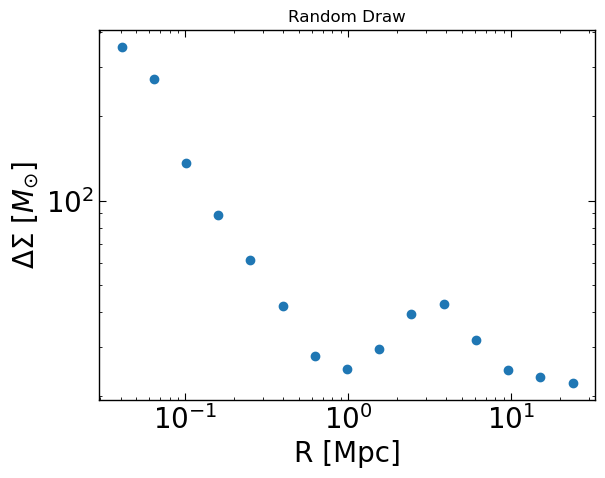

In [29]:
ix = np.random.randint(profile_all.shape[0])
# ix = 3
plt.loglog()
plt.scatter(radii, profile_all[ix])
plt.title('Random Draw')
plt.xlabel(r'R [Mpc]')
plt.ylabel(r'$\Delta \Sigma \, \, [M_{\odot}]$')

In [30]:
mock

haloid,Mvir,redshift,cosi,pid,rs,M200m,R200m,Sigma,DeltaSigma,rho,M200,R200,MEM_MATCH_ID,RA,DEC,Z,Z_COS,P_BCG,Z_LAMBDA,LAMBDA_CHISQ,LAMBDA_CHISQ_E,LAMBDA_CHISQ_ZORIG,SCALEVAL,LAMBDA_ZRED,LAMBDA_ZRED_E,MASKFRAC,GEOMASKFRAC,R_LAMBDA,R_MASK,Z_LAMBDA_E,NCROSS,Z_LAMBDA_NITER,DLAMBDA_DZ,DLAMBDA_DZ2,DLAMBDAVAR_DZ,DLAMBDAVAR_DZ2,C_LAMBDA,C_LAMBDA_ERR,MAG_LAMBDA_ERR,PZBINS,PZ,Z_LAMBDA_RAW,Z_LAMBDA_E_RAW,BCG_SPEC_Z,LIM_EXPTIME,LIM_LIMMAG_DERED,LIM_LIMMAG,LIM_LIMMAG_HARD,MU_STAR,MU_STAR_ERR,lambda_mor,mustar_mor
int32,float32,float64,float64,int32,float64,float32,float64,float64[15],float64[15],float64[10],float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32[3],float32[3],float32[4],float32[21],float32[21],float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64
927011,67180000000000.0,0.32129502296447754,0.0493361,-1,0.153435,71999500000000.0,1.02684,687.6303158625412 .. 17.94479240757588,-21.009727248105214 .. 2.303207391199313,2178226498771693.5 .. 503991597033.93005,67180000000000.0,0.920502,83659,-42.68707121753749,-2.2699395003325264,0.32129502,0.32240096,1.0,0.29508114,11.308149,4.421,11.308149,1.5201979,5.496004,1.8859599,0.34834605,0.0,0.6466634,0.96999514,0.021968598,0,4.0,-0.13628136,-813.556,-25.539,-7945.5103,1.5532275 .. 0.30276462,0.004215956 .. 0.001953539,0.003551543 .. 0.0,0.1319275 .. 0.4582348,4.6803337e-19 .. 1.6777544e-06,0.30003133,0.019447086,-1.0,0.060046393,21.323307,21.323307,23.33665,55.13490186726909,15.129583717781587,12.997168754888262,1628824210592.8164
927998,19660000000000.0,0.3205868899822235,0.178295,-1,0.183352,22303100000000.0,0.694974,311.34160504036714 .. 18.374717459592997,37.19347864947478 .. 1.2994938365065096,1373541979616634.8 .. 305181131216.41174,19660000000000.0,0.61103,583836,-42.24797103113116,-1.949667563663084,0.3205869,0.32168326,1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.042421903,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,-1.0 .. -1.0,-1.0 .. -1.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,-1.0,0.19611365,22.218992,22.231089,23.33665,41.92753971791975,14.28440131000884,5.511520676516353,709470062844.0934
2545389,68890000000000.0,0.27058446407318115,0.37468,-1,0.223423,91154710000000.0,1.11086,469.1737007476693 .. 15.90097191373355,115.09039698599864 .. 2.753597969323336,2219173286702298.8 .. 1519260804499.2036,68890000000000.0,0.917785,79738,-52.84926974610653,-42.0517754044981,0.27058446,0.27059728,1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.027480915,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,-1.0 .. -1.0,-1.0 .. -1.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,-1.0,0.17292078,22.134556,22.134556,23.33665,75.17978438169001,28.065401761466184,11.715710449162497,1699300254692.4453
2545393,88940000000000.0,0.27038249373435974,0.557151,-1,0.55728,105052300000000.0,1.16474,542.0784591288408 .. 16.14773575478276,-57.00905916180685 .. 2.5884544516698047,1642214180825270.8 .. 920412980488.0205,88940000000000.0,0.999439,49132,-52.72529328242206,-42.05313550692125,0.2703825,0.27077192,1.0,0.2726077,12.909922,2.2422812,12.909922,1.0107747,8.592764,1.683498,0.011844758,0.0,0.6640254,0.99603814,0.012795136,1,7.0,16.436996,-4891.07,54.50159,-19902.953,1.4195611 .. 0.29340506,0.0006993837 .. 0.00028456797,0.0005785313 .. 0.0,0.19574621 .. 0.3494692,6.227082e-10 .. 2.574587e-06,0.27617714,0.009283012,-1.0,0.17907387,22.145226,22.161373,23.33665,81.77789884880814,21.3046707925232,13.800182315972194,2204435902892.787
2545753,76890000000000.0,0.263835608959198,0.125772,-1,0.162836,81108270000000.0,1.06845,531.6249357975245 .. 17.51952583340207,124.49326826468936 .. 1.566832787886304,2128660225006729.0 .. 356406746880.90045,76890000000000.0,0.950669,64954,-51.53433281206111,-39.82394748123761,0.2638356,0.2644128,1.0,0.24406444,12.757372,2.730836,12.757372,1.1628395,7.357111,1.6438206,0.14655606,0.0,0.6624487,0.9936731,0.010842432,1,5.0,-3

# Effective $\Sigma_{\rm c}$ 

The crital density is for a given object. For instance, when a galaxy is observed on an Einstein ring the critical density of that observation is the redshift of the source galaxy. In the weak lensing regime, we have several sources. Our sources depends of how many galaxies we select, i.e. the galaxies by a given survey.

If we had a complete catalog the sources would be all the galaxies behind the cluster. And the redshift distribution would increase monotonichally.

In [31]:
zbins = np.linspace(0.05, 0.94, 21)
zmean = 0.5*(zbins[:-1] + zbins[1:])
pdfz, _ = np.histogram(redshift_pdz, bins=zbins, density=True)

In [32]:
from scipy.interpolate import interp1d
zsources = np.linspace(0.1, 1.3, 100)
pz = interp1d(zmean, pdfz, fill_value="extrapolate")(zsources)

### Selection Function

A survey is magnitude limited. Magnitude selection is very different of volume limited. High redshift galaxies if they're brighter they appear in our selection. This effect is well known and its name is Malquimist Bias. In this mock we will do something simple, a redshift limit with a tail. We use a function that looks like the magnitude selection. In the future I hope to improve this redshift selection function.

In [33]:
def completeness_formula(m, A=0.94, m50=24.88, rho=0.65):
    """ Completeness functional form
    See eq 7 from Martin et al. 2016
    """
    # modidfication for redshift
    rho*= (1+m)
    denominator = 1+np.exp((m-m50)/rho)
    res = A/denominator
    return res

# based on the completeness formula I'll do something to redshift
# des redshift limit
zlim = 0.8
# redshift window size of redshift falling
z_window_length = 0.05
sel_function = completeness_formula(zsources, m50= zlim, rho=z_window_length)

In [34]:
# help(interp1d)

Text(0, 0.5, 'p(z)')

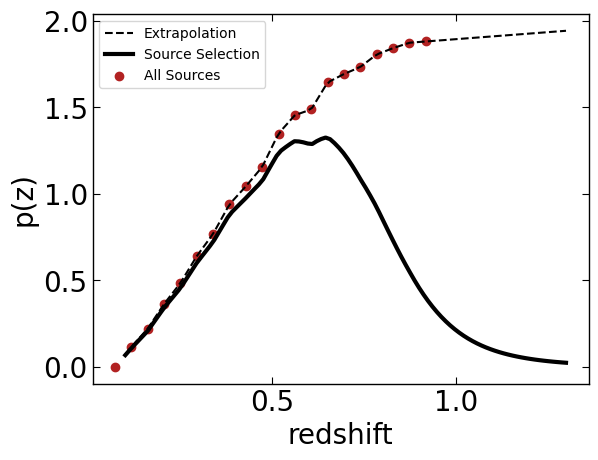

In [35]:
plt.plot(zsources, pz, 'k--', label='Extrapolation')
plt.plot(zsources, pz*sel_function, 'k', lw=3, label='Source Selection')
plt.scatter(zmean, pdfz, color='firebrick', label='All Sources')
plt.legend()
plt.xlabel('redshift')
plt.ylabel(r'p(z)')

In [36]:
print('save z source distribution: %s'%'pdfz_mock_buzzrd_y3like.npz')
pz_norm = pz*sel_function/np.trapz(pz*sel_function,x=zsources)
np.savez('pdfz_mock_buzzrd_y3like.npz', z=zsources, pdfz=pz_norm)

save z source distribution: pdfz_mock_buzzrd_y3like.npz


In [37]:
pzsel = np.load('pdfz_mock_buzzrd_y3like.npz')